# Experiment 3:  
This experiment implements optimization over feature tuning. Given an LSTNET model, we select the parameters that yielded the best performance on forecasting L1 returns (instead of log-returns like in Experiment 2). In this case, we will begin adding features, but varrying their calculation. We choose to vary the calculation period for RSI, Williams %, and ADX. After running optimization, we will now have tuned features that yield the best performance with our model. Similarly to Experiment 2, in practice, as we come across a new set of parameters, we will train and save a new model. If those parameters are sampled again, we'll instead load the model. In the interest of time, we have pre-trained a handful of models and tightened the variance of the priors for faster inference.

### Imports

In [1]:
from qbo import QBO
from qmc import QMC
import numpy as np
import pandas as pd
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeWashington
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from lstnet2 import LSTNet

import yfinance as yf
import seaborn as sns

### Download Data

In [2]:
data = yf.download("JPY=X", start="2022-01-01", end="2025-01-01")
historical_data = pd.DataFrame(data)
historical_data.to_csv("data/usdjpy.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
historical_data.head()

Price,Close,High,Low,Open,Volume
Ticker,JPY=X,JPY=X,JPY=X,JPY=X,JPY=X
Date,,,,,
2022-01-03,115.141998,115.360001,114.973999,115.136002,0
2022-01-04,115.328003,116.339996,115.299004,115.316002,0
2022-01-05,116.174004,116.235001,115.626999,116.165001,0
2022-01-06,116.127998,116.179001,115.653999,116.128998,0
2022-01-07,115.864998,116.029999,115.591003,115.870003,0


Text(0.5, 1.0, 'USD/JPY Close')

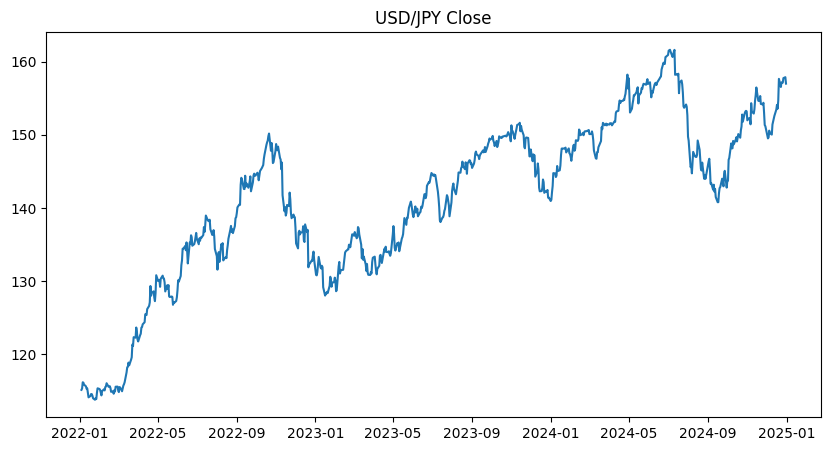

In [4]:
# Display closing price
# This is non-linear, non-stationary. Models WILL struggle to define relationships. Future datapoints could make gradients unstable
f = plt.figure(figsize=(10, 5))
plt.plot(historical_data["Close"].index, historical_data["Close"])
plt.title("USD/JPY Close")

Text(0.5, 1.0, 'USD/JPY Log-Return')

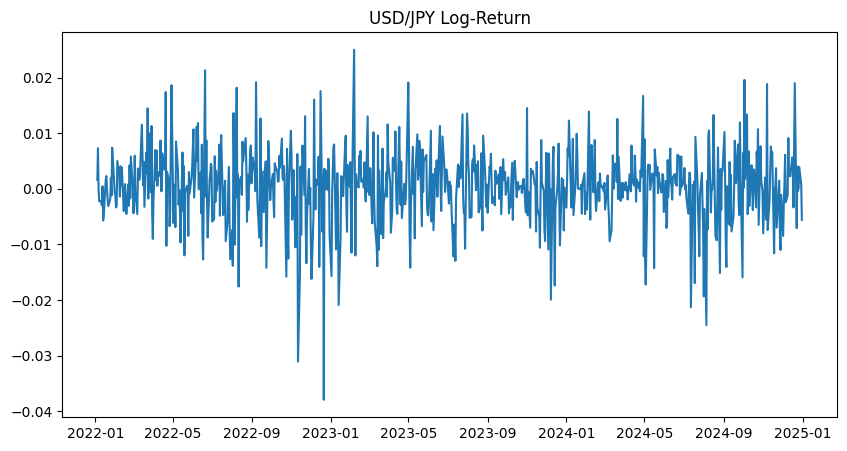

In [5]:
# Here, we compute the log returns. This allows the data to now be stationary
# This also creates a form of normalization, stabilizing gradients for future inputs
f = plt.figure(figsize=(10, 5))
y = np.log(historical_data["Close"].to_numpy()).squeeze()
y_delta = y[1:] - y[:-1]

plt.plot(historical_data["Close"].index[1:], y_delta)
plt.title("USD/JPY Log-Return")

### Experiment Config

In [6]:
# Quantum simulation device
device = FakeWashington()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

# Quantum params
quantum_noise = False
max_iter = 5000 # 11s for 100, 10min on 5000 for experiment
total_runs = 5
uncertainty_dim = 3 # number of qubits to use (exponentially increases runtime) 6 is default

In [7]:
# Lookahead prior sampling
dim1 = np.linspace(0, 1, 3) # add these alongside prior domain. treat as arb gridspace
dim2 = np.linspace(0, 1, 3)
dim3 = np.linspace(0, 1, 3)
dim = 3
domain = []
for a in dim1:
    for b in dim2:
        for c in dim3:
            domain.append([a, b, c])
domain = np.array(domain)
ls = np.array([0.2] * dim) # length scale
v_kernel = 0.5
obs_noise = 0.05 ** 2
M_target = 200

# RBF kernel
s = np.random.multivariate_normal(np.zeros(dim), 1 / (ls ** 2) * np.identity(dim), M_target)
b = np.random.uniform(0, 2 * np.pi, M_target)

fourier_features = {
    "s": s, # frequencies
    "b": b, # phases
    "v_kernel": v_kernel,
    "obs_noise": obs_noise,
    "domain": domain
}

pbounds = {}
for i in range(dim):
    pbounds["x" + str(i+1)] = (0, 1)

ts = np.arange(1, max_iter)
beta_t = 1 + np.sqrt(np.log(ts) ** 2)

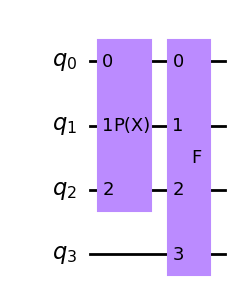

In [8]:
dummy_qmc = QMC(num_uncertainty=uncertainty_dim, means=1.0)
dummy_qmc.mc_circuit.draw(output="mpl")

### Data Loader and Feature Computations

In [9]:
class USDJPY(Dataset):
    def __init__(self, data: np.ndarray, period: int):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.period = period
    
    def __len__(self):
        return len(self.data) - self.period

    def __getitem__(self, index):
        x = self.data[index: index + self.period]
        y = self.data[index + self.period][0]
        return x, y

In [10]:
def get_rsi(historical: pd.DataFrame, period: int):
    close = historical["Close"].to_numpy()
    delta = np.diff(close, axis=0)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    
    avg_gain = np.ones_like(close)
    avg_loss = np.ones_like(close)
    avg_gain[period] = np.mean(gain[:period])
    avg_loss[period] = np.mean(loss[:period])
    
    for i in range(period + 1, len(close)):
        avg_gain[i] = (avg_gain[i - 1] * (period - 1) + gain[i - 1]) / period
        avg_loss[i] = (avg_loss[i - 1] * (period - 1) + loss[i - 1]) / period
    
    rsi = 100.0 - (100.0 / (1.0 + (avg_gain / avg_loss)))
    return rsi


def get_williamsr(historical: pd.DataFrame, period: int):
    high = historical["High"].to_numpy()
    low = historical["Low"].to_numpy()
    close = historical["Close"].to_numpy()
    williams = np.full_like(close, -50.)
    
    for i in range(period - 1, len(close)):
        max_high = np.max(high[i - period + 1: i + 1])
        min_low = np.min(low[i - period + 1: i + 1])
        williams[i] = -100 * (max_high - close[i]) / (max_high - min_low)
    
    return williams


def get_adx(historical: pd.DataFrame, period: int):
    high = historical["High"].to_numpy()
    low = historical["Low"].to_numpy()
    close = historical["Close"].to_numpy()
    
    tr = np.maximum(high[1:], close[:-1]) - np.minimum(low[1:], close[:-1])
    up_move = high[1:] - high[:-1]
    down_move = low[:-1] - low[1:]

    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)

    tr14 = np.ones_like(close)
    plus_dm14 = np.ones_like(close)
    minus_dm14 = np.ones_like(close)

    tr14[period] = np.sum(tr[:period])
    plus_dm14[period] = np.sum(plus_dm[:period])
    minus_dm14[period] = np.sum(minus_dm[:period])

    for i in range(period + 1, len(close)):
        tr14[i] = tr14[i - 1] - (tr14[i - 1] / period) + tr[i - 1]
        plus_dm14[i] = plus_dm14[i - 1] - (plus_dm14[i - 1] / period) + plus_dm[i - 1]
        minus_dm14[i] = minus_dm14[i - 1] - (minus_dm14[i - 1] / period) + minus_dm[i - 1]

    plus_di14 = 100 * plus_dm14 / tr14
    minus_di14 = 100 * minus_dm14 / tr14
    dx = 100 * np.abs(plus_di14 - minus_di14) / (plus_di14 + minus_di14)

    adx = np.full_like(close, 50.0)
    adx[period * 2] = np.mean(dx[period: period * 2])
    for i in range(period * 2 + 1, len(close)):
        adx[i] = ((adx[i - 1] * (period - 1)) + dx[i - 1]) / period

    return adx

### Model Priors and Test Loop

In [11]:
# Preloaded prior selection
rsi_params = {0: 7, 1: 14, 2: 21}
wil_params = {0: 7, 1: 14, 2: 21}
adx_params = {0: 7, 1: 14, 2: 21}

In [12]:
def forecast(loader: DataLoader, model: nn.Module):
    model.eval()
    predictions = []
    with torch.no_grad():
        for sequences, _ in loader:
            preds = model(sequences)
            predictions.extend(preds.numpy())
    return np.asarray(predictions)

In [ ]:
def reward_function(param, eps, obs_noise):    
    # Rescale
    parameter_range = [[0.0, 2.0], [0.0, 2.0], [0.0, 2.0]]
    rsi_period = rsi_params[int(param[0] * (parameter_range[0][1] - parameter_range[0][0]) + parameter_range[0][0])]
    wil_period = wil_params[int(param[1] * (parameter_range[1][1] - parameter_range[1][0]) + parameter_range[1][0])]
    adx_period = adx_params[int(param[2] * (parameter_range[2][1] - parameter_range[2][0]) + parameter_range[2][0])]

    # Construct data loader and load corresponding model
    horizon = 20
    l1_return = np.diff(historical_data["Close"].to_numpy(), axis=0)   
    rsi_data = get_rsi(historical_data, period=rsi_period) / 100.0
    wil_data = get_williamsr(historical_data, period=wil_period) / -100.0
    adx_data = get_adx(historical_data, period=adx_period) / 100.0
    features = np.concatenate((l1_return[-(100 + horizon):], rsi_data[-(100 + horizon):], wil_data[-(100 + horizon):], adx_data[-(100 + horizon):]), axis=-1)
    
    test_window = features[-(100 + horizon):]
    test_dataset = USDJPY(test_window, period=horizon)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    model = LSTNet(period=horizon, num_features=4, rnn_dim=64, cnn_dim=64, skip_dim=32)
    model.load_state_dict(torch.load(f"models2/r{rsi_period}-w{wil_period}-a{adx_period}.pth"))
    
    # Forecast test
    predictions = forecast(test_loader, model)
    i_mse = 1 / np.mean((predictions - test_window[horizon:, 0]) ** 2)
    
    # Update beliefs via QBO and QMC
    qmc = QMC(num_uncertainty=uncertainty_dim, means=i_mse, obs_noise=obs_noise)
    result, queries = qmc.estimate(eps)
    return result.estimation_processed, i_mse, queries

### Apply QBO with Q-GP-UCB

In [14]:
quantum_BO = None
linear = False
all_gp_res = []
for itr in range(total_runs):
    print("Optimization Round", itr + 1)
    np.random.seed(itr)

    quantum_BO = QBO(
        reward_func=reward_function,
        pbounds=pbounds,
        beta_t=beta_t,
        random_features=fourier_features,
        bandits=linear,
        domain=domain
    )
    quantum_BO.maximize(n_iter=max_iter, init_points=1)
    all_gp_res.append(quantum_BO.res)

Optimization Round 1
Shot 0 ------ x_t: [0.5 0.5 0.5], y_t: 0.6856935299158862
Shot 1 ------ x_t: [0.5 0.5 0.5], y_t: 0.6856935299158862
Shot 2 ------ x_t: [0.5 0.5 0.5], y_t: 0.6856935299158862
Shot 3 ------ x_t: [0.5 0.5 0.5], y_t: 0.6856935299158862
Shot 4 ------ x_t: [0.5 0.5 0.5], y_t: 0.6856935299158862
Shot 5 ------ x_t: [0.5 0.5 0.5], y_t: 0.6856935299158862
Shot 6 ------ x_t: [0.5 0.5 0.5], y_t: 0.6856935299158862
Shot 7 ------ x_t: [0.5 0.5 0.5], y_t: 0.6838353428743409
Shot 8 ------ x_t: [0.5 0.5 0.5], y_t: 0.6826637006565541
Shot 9 ------ x_t: [0.5 0.5 0.5], y_t: 0.6803630458651233
Shot 10 ------ x_t: [0.5 0.5 0.5], y_t: 0.6806514462186363
Shot 11 ------ x_t: [0.5 0.5 0.5], y_t: 0.6801345343925606
Shot 12 ------ x_t: [0.5 0.5 0.5], y_t: 0.7053553751028661
Shot 13 ------ x_t: [0.5 0.5 0.5], y_t: 0.7049619889949371
Shot 14 ------ x_t: [0.5 0.5 0.5], y_t: 0.7050426919240486
Shot 15 ------ x_t: [0.5 0.5 0.5], y_t: 0.7004671295303103
Shot 16 ------ x_t: [0.5 0.5 0.5], y_t: 0.700

### Param Distribution

In [15]:
# Retrieve collective param results. Rescale
parameter_range = [0.0, 2.0] # unique for this, since all params have same range

# Individual param distributions
x1_dist = {rsi_params[k]: 0 for k in range(3)}
x2_dist = {wil_params[k]: 0 for k in range(3)}
x3_dist = {adx_params[k]: 0 for k in range(3)}
for gp_res in all_gp_res:
    for param in gp_res["all"]["params"]:
        # Rescale
        param = (param * (parameter_range[1] - parameter_range[0]) + parameter_range[0]).astype("int")
        # Frequencies
        x1, x2, x3 = rsi_params[param[0]], wil_params[param[1]], adx_params[param[2]]
        for xn, dist in zip([x1, x2, x3], [x1_dist, x2_dist, x3_dist]):
            dist[xn] += 1

# Relational param distribution
param_dist = {}
for gp_res in all_gp_res:
    for param in gp_res["all"]["params"]:
        # Rescale
        param = (param * (parameter_range[1] - parameter_range[0]) + parameter_range[0]).astype("int")
        param[0] = rsi_params[param[0]]
        param[1] = wil_params[param[1]]
        param[2] = adx_params[param[2]]
        # Frequencies
        param = tuple(param.tolist())
        if param not in param_dist:
            param_dist[param] = 0
        param_dist[param] += 1
    
print(x1_dist)
print(x2_dist)
print(x3_dist)
print(param_dist)

{7: 13, 14: 90, 21: 32}
{7: 49, 14: 53, 21: 33}
{7: 49, 14: 54, 21: 32}
{(14, 14, 14): 21, (14, 21, 7): 22, (14, 7, 14): 21, (14, 14, 21): 1, (14, 7, 21): 1, (21, 14, 7): 1, (14, 14, 7): 2, (21, 7, 7): 1, (14, 21, 14): 2, (21, 7, 14): 1, (14, 21, 21): 1, (21, 21, 7): 1, (21, 14, 14): 2, (7, 7, 7): 1, (21, 21, 14): 2, (14, 7, 7): 19, (7, 21, 21): 1, (7, 7, 14): 2, (21, 21, 21): 2, (7, 7, 21): 2, (7, 14, 14): 2, (21, 14, 21): 21, (7, 14, 21): 2, (7, 21, 14): 1, (21, 7, 21): 1, (7, 14, 7): 1, (7, 21, 7): 1}


In [16]:
# Extract frequencies
x1_samples = []
x2_samples = []
x3_samples = []    
for value, freq in x1_dist.items():
    x1_samples.extend([value] * freq)
for value, freq in x2_dist.items():
    x2_samples.extend([value] * freq)
for value, freq in x3_dist.items():
    x3_samples.extend([value] * freq)

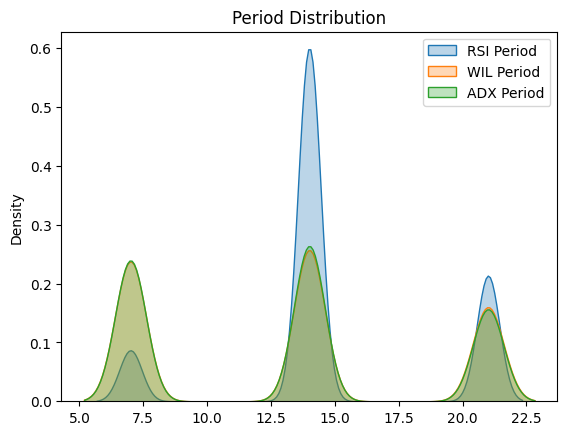

In [17]:
# KDE plot
sns.kdeplot(x1_samples, bw_adjust=0.3, fill=True, label="RSI Period", alpha=0.3)
sns.kdeplot(x2_samples, bw_adjust=0.3, fill=True, label="WIL Period", alpha=0.3)
sns.kdeplot(x3_samples, bw_adjust=0.3, fill=True, label="ADX Period", alpha=0.3)

# Axis labels
plt.title("Period Distribution")
plt.legend()

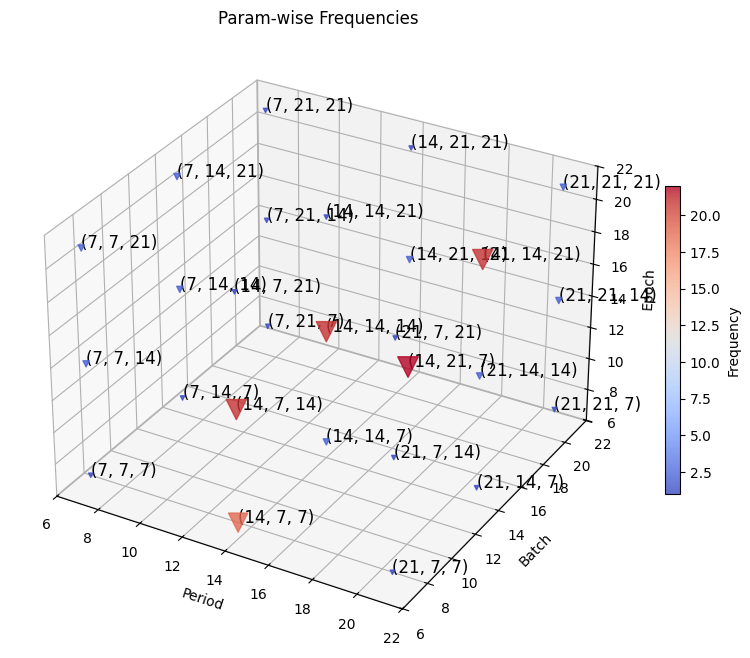

In [ ]:
# Extract coordinates and frequencies
x = [key[0] for key in param_dist]
y = [key[1] for key in param_dist]
z = [key[2] for key in param_dist]
freq = list(param_dist.values())

# Set up 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use frequency as size or color
scatter = ax.scatter(x, y, z, c=freq, s=[f * 10 for f in freq], cmap='coolwarm', alpha=0.8, marker="v")

# Annotate each point with its coordinates
for xi, yi, zi in zip(x, y, z):
    ax.text(xi, yi, zi, f'({xi}, {yi}, {zi})', size=12, zorder=1, color='black')

# Colorbar to show frequency scale
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
cbar.set_label('Frequency')

# Axis labels
ax.set_xlabel('RSI')
ax.set_ylabel('WIL')
ax.set_zlabel('ADX')
ax.set_title('Param-wise Frequencies')

plt.show()

### True Best Params

In [19]:
parameter_range = [0.0, 2.0] # unique for this, since all params have same range
max_params = {}
for gp_res in all_gp_res:
    val, params = gp_res["max"]["max_val"], gp_res["max"]["max_params"]
    params = [(p * (parameter_range[1] - parameter_range[0]) + parameter_range[0]).astype("int") for p in params.values()]
    params[0] = rsi_params[params[0]]
    params[1] = wil_params[params[1]]
    params[2] = adx_params[params[2]]
    max_params[val] = params

best_params = max_params[max(max_params.keys())]
print("Confidence:", max(max_params.keys()))
print("Params (Period, Batch, Epoch):", best_params)

Confidence: 0.7889294429936129
Params (Period, Batch, Epoch): [14, 7, 7]


### Test Model

In [27]:
# Retrieve best params and relevant dataset, model
rsi_period, wil_period, adx_period = best_params

horizon = 20
l1_return = np.diff(historical_data["Close"].to_numpy(), axis=0)   
rsi_data = get_rsi(historical_data, period=7) / 100.0
wil_data = get_williamsr(historical_data, period=7) / -100.0
adx_data = get_adx(historical_data, period=7) / 100.0
features = np.concatenate((l1_return[-(100 + horizon):], rsi_data[-(100 + horizon):], wil_data[-(100 + horizon):], adx_data[-(100 + horizon):]), axis=-1)

test_window = features[-(100 + horizon):]
test_dataset = USDJPY(test_window, period=horizon)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = LSTNet(period=horizon, num_features=4, rnn_dim=64, cnn_dim=64, skip_dim=32)
model.load_state_dict(torch.load(f"models2/r{rsi_period}-w{wil_period}-a{adx_period}.pth"))

# Forecast
predictions = forecast(test_loader, model)
mse = np.mean((predictions - test_window[horizon:, 0]) ** 2)
print("MSE:", mse)

MSE: 1.2785745508268962


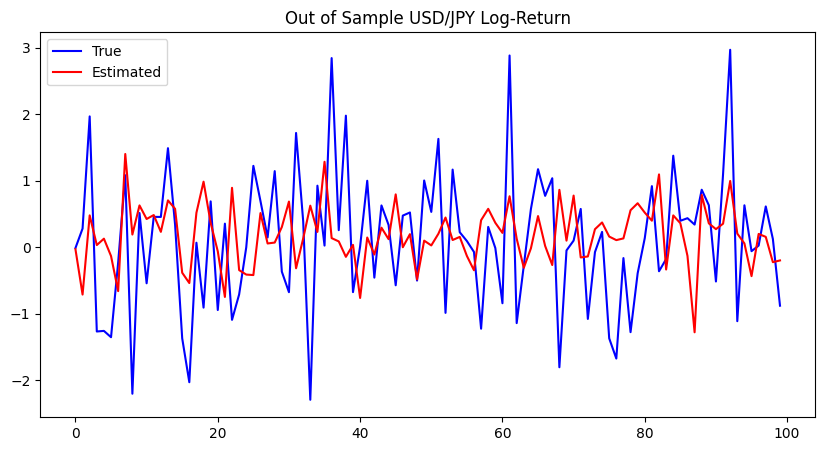

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test_window) - horizon), test_window[horizon:, 0], color="blue", label="True")
plt.plot(np.arange(len(predictions)), predictions, color="red", label="Estimated")
plt.title("Out of Sample USD/JPY Log-Return")
plt.legend()

In [34]:
# Retrieve best params and relevant dataset, model
rsi_period, wil_period, adx_period = best_params

horizon = 20
l1_return = np.diff(historical_data["Close"].to_numpy(), axis=0)   
rsi_data = get_rsi(historical_data, period=7) / 100.0
wil_data = get_williamsr(historical_data, period=7) / -100.0
adx_data = get_adx(historical_data, period=7) / 100.0
features = np.concatenate((l1_return[99: -100], rsi_data[100: -100], wil_data[100: -100], adx_data[100: -100]), axis=-1)

test_window = features
test_dataset = USDJPY(test_window, period=horizon)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = LSTNet(period=horizon, num_features=4, rnn_dim=64, cnn_dim=64, skip_dim=32)
model.load_state_dict(torch.load(f"models2/r{rsi_period}-w{wil_period}-a{adx_period}.pth"))

# Forecast
predictions = forecast(test_loader, model)
mse = np.mean((predictions - test_window[horizon:, 0]) ** 2)
print("MSE:", mse)

MSE: 1.9378519777680476


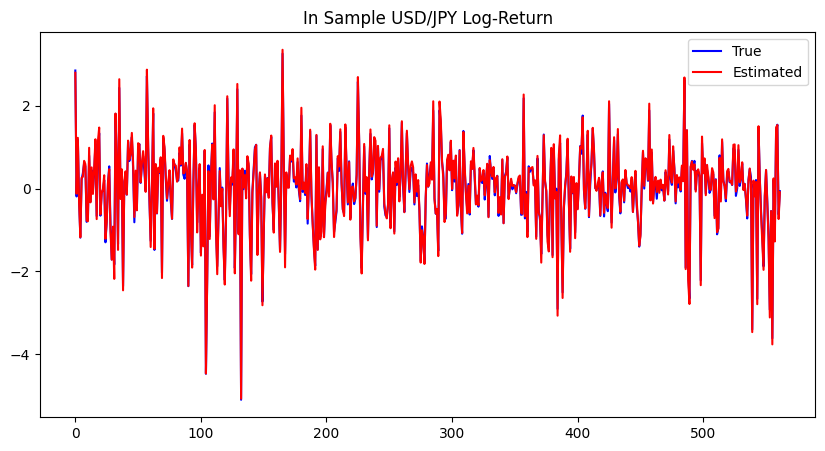

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test_window) - horizon), test_window[horizon:, 0], color="blue", label="True")
plt.plot(np.arange(len(predictions)), predictions, color="red", label="Estimated")
plt.title("In Sample USD/JPY Log-Return")
plt.legend()